<a href="https://colab.research.google.com/github/sudhirshahu51/RAG/blob/main/Langgraph_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LangGraph enables us to create stateful, multi-actor applications utilizing LLMs as easily as possible. It extends the capabilities of LangChain, introducing the ability to create and manage cyclical graphs, which are pivotal for developing sophisticated agent runtimes. The core concepts of LangGraph include: graph structure, state management, and coordination.

[Tutorial Video ](https://www.youtube.com/watch?v=gqvFmK7LpDo)

Chatbot with Langraph

In [ ]:
!pip install langgraph langsmith langchain langchain_groq langchain_community --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.7 MB/s eta 0:00:00


In [ ]:
!pip install arxiv wikipedia --quiet

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.1 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
groq_key = userdata.get('GROQ_API')
langsmith_key = userdata.get('LANGSMITH_API')

In [ ]:
import os
os.environ['LANGCHAIN_API_KEY'] = langsmith_key
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = 'Langgraph_chatbot'

In [ ]:
from langchain_groq import ChatGroq

In [ ]:
llm = ChatGroq(groq_api_key = groq_key, model_name = 'gemma2-9b-it')
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7fcbdc78df60>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7fcbdc78e9e0>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

#Tools

In [ ]:
## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [ ]:
wiki_tool.invoke("who is Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10'

In [ ]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [ ]:

tools=[wiki_tool, arxiv_tool]

#Start Building Chatbot Using Langraph

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

#Chatbot Without Tools

In [ ]:
class State(TypedDict):
  #Messages have the type 'list'. The 'add_messages' function
  # in the annotation defines how this state key should be updated
  # in this case, it appends messages to the list, rather than overwriting them.
  messages: Annotated[list[str], add_messages]


graph_builder = StateGraph(State)

In [ ]:
graph_builder

In [ ]:
def chatbot(state: State):
  return {'messages': llm.invoke(state['messages'])}

graph_builder.add_node('chatbot', chatbot)
graph_builder.add_edge(START, 'chatbot')
graph_builder.add_edge('chatbot', END)
graph = graph_builder.compile()

In [ ]:
graph=graph_builder.compile()

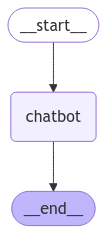

In [ ]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [ ]:
while True:
  user_input = input('User: ')
  if user_input.lower()  in ['quit', 'q']:
    print('Good Bye')
    break
  for event in graph.stream({'messages':('user', user_input)}):
    print(event.values())
    for value in event.values():
      print(value['messages'])
      print('Assistant', value['messages'].content)

#Chatbot With Tools

In [ ]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [ ]:
graph_builder= StateGraph(State)

In [ ]:
llm_with_tools=llm.bind_tools(tools=tools)

In [ ]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [ ]:
from langgraph.prebuilt import ToolNode,tools_condition

In [ ]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [ ]:
graph=graph_builder.compile()

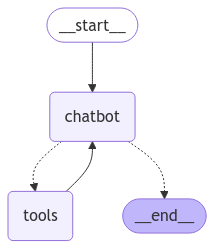

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
user_input="Hi there!, My name is John"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is John
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_xys1)
 Call ID: call_xys1
  Args:
    query: John


/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found
================================== Ai Message ==================================

No problem, John. Is there anything else I can help you with?


In [ ]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_z9ae)
 Call ID: call_z9ae
  Args:
    query: RLHF
================================= Tool Message =================================
Name: wikipedia

Page: Reinforcement learning from human feedback
Summary: In machine learning, reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other mo
================================== Ai Message ==================================

Reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other models to behave in a way that maximizes th